In [1]:
import numpy as np
import matplotlib.pylab as plt
from lsst.sims.featureScheduler.utils import schema_converter
from lsst.sims.utils import _angularSeparation
import sys

In [2]:
# OK, we have satellites at 550 km, circular orbits. inclination of 53 degrees. and 24 orbital planes with 66 sats each.
# Orbital planes are 15 degrees apart. 

# Pumping things up to 40,000 satellites

In [3]:
# So, let's compute the x,y,z positions of all the satellites at a given time. and then the x,y,z of the site.
# rotate and translate so site is at 0,0 pointing up, and calc the alt az of all the sats

In [4]:
R_earth = 6.37e8  # cm
r_orbit = R_earth + 550*100*1000  #cm
G = 6.67e-8  #cgs
M_earth = 5.98e27  #g
lat_lsst = -0.527864360  # radians

In [5]:
v_orbit = (G * M_earth/ r_orbit)**0.5  #cm/s
v_orbit = v_orbit/(100 *1000)  # km/s
p_orbit = 2.*np.pi * r_orbit / (v_orbit*100*1000) / (3600*24.)  # Days

In [6]:
print(v_orbit,'km/s', p_orbit*24, 'hours')

7.5920745106803675 km/s 1.5908271720476583 hours


In [7]:
# Define all our rotation matricies
def rot_x(x,y,z, theta):
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    x_out = x
    y_out = cos_theta*y-sin_theta*z
    z_out = sin_theta*y+cos_theta*z
    return x_out, y_out, z_out

def rot_y(x,y,z, theta):
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    x_out = cos_theta*x + sin_theta*z
    y_out = y
    z_out = -sin_theta*x + cos_theta*z
    return x_out, y_out, z_out
    
def rot_z(x,y,z, theta):
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    x_out = cos_theta*x-sin_theta*y
    y_out = sin_theta*x+cos_theta*y
    z_out = z
    return x_out, y_out, z_out

In [8]:
def generate_sat_xyz(delta_t, inclination=np.radians(53.), n_sats=420 , n_tilt=96 ):#n_sats=66, n_tilt=24):
    """ Generate x,y,z positions of all the satellites at a given time
    """
    
    theta_start = np.arange(n_sats)/n_sats*2*np.pi
    theta_start += delta_t/p_orbit*2*np.pi
    x_start = r_orbit*np.cos(theta_start)
    y_start = r_orbit*np.sin(theta_start)
    z_start = np.zeros(y_start.size)
    # now to incline the points
    x_start, y_start, z_start = rot_y(x_start, y_start, z_start, inclination)
    x = []
    y = []
    z = []
    for rot_angle in np.radians(np.arange(0,n_tilt)*360./n_tilt):
        x_new, y_new, z_new = rot_z(x_start, y_start, z_start, rot_angle)
        x.append(x_new)
        y.append(y_new)
        z.append(z_new)
    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    return x,y,z
    

In [9]:

x,y,z = generate_sat_xyz(0)

In [10]:
from mpl_toolkits.mplot3d import Axes3D


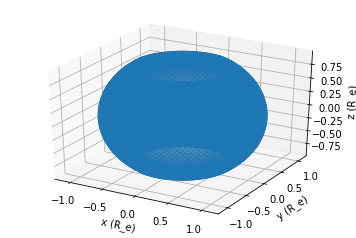

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x/R_earth,y/R_earth,z/R_earth, alpha=.1)
ax.set_xlabel('x (R_e)')
ax.set_ylabel('y (R_e)')
ax.set_zlabel('z (R_e)')


In [12]:
(x**2+y**2+z**2)**0.5, r_orbit

(array([  6.92000000e+08,   6.92000000e+08,   6.92000000e+08, ...,
          6.92000000e+08,   6.92000000e+08,   6.92000000e+08]), 692000000.0)

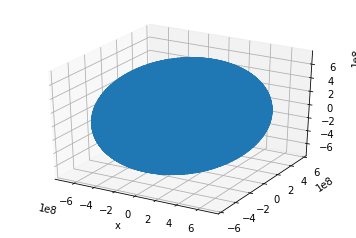

In [13]:
x_new,y_new,z_new = rot_x(x,y,z, -np.pi/2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_new,y_new,z_new, alpha=.3)
ax.set_xlabel('x')

In [14]:
(x**2+y**2+z**2)**0.5, r_orbit, z.max(), R_earth

(array([  6.92000000e+08,   6.92000000e+08,   6.92000000e+08, ...,
          6.92000000e+08,   6.92000000e+08,   6.92000000e+08]),
 692000000.0,
 552655772.9527266,
 637000000.0)

In [15]:
# ok, now the motion of the observatory is a circle with period 24hr - 4 min. 
# So we rotate the points around the z-axis by negative the LMST. Then around x(?) by -dec + 90 degrees. 
# Subtract the radius of earth from z. then convert points to alt, az. 

In [16]:
def xyx2altaz(x,y,z):
    r = (x**2+y**2+z**2)**0.5
    az = (np.arctan2(y, x) + np.pi)
    alt = np.arcsin(z/r)
    return alt, az

In [17]:
def sats2altaz(x,y,z, lmst, latitude=lat_lsst):
    x,y,z = rot_z(x,y,z, -lmst)
    x,y,z = rot_y(x,y,z, latitude-np.pi/2.) # Need to double check if this should be positive or negative
    z -= R_earth
   
    alt, az = xyx2altaz(x,y,z)
    return alt, az
    

In [18]:
# ok, let's put an object at 2 earth radii, lmst=90 degrees, dec at lsst lat
r_test = 2.*R_earth
lmst = np.pi/2
z_test = r_test*np.sin(lat_lsst)
x_test = r_test*np.cos(lat_lsst)*np.cos(lmst)
y_test =  r_test*np.cos(lat_lsst)*np.sin(lmst)
x_test,y_test,z_test

(6.7391649468456597e-08, 1100589157.8760061, -641700479.63655424)

In [19]:
rot_y(*rot_z(x_test,y_test,z_test, -lmst), lat_lsst-np.pi/2)

(1.1920928955078125e-07, 0.0, 1274000000.0)

In [20]:
np.degrees(sats2altaz(x_test,y_test,z_test, lmst))

array([  90.,  180.])

In [21]:
alt,az = sats2altaz(x,y,z,0.)

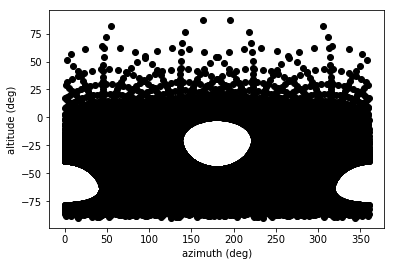

In [22]:
plt.plot(np.degrees(az),np.degrees(alt), 'ko')
plt.xlabel('azimuth (deg)')
plt.ylabel('altitude (deg)')

In [23]:
print(np.size(np.where(np.degrees(alt) > 30.)[0]))

158


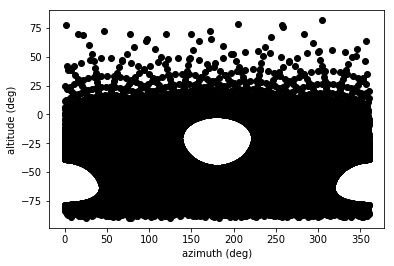

In [23]:
alt,az = sats2altaz(x,y,z,np.radians(10.))
plt.plot(np.degrees(az),np.degrees(alt), 'ko')
plt.xlabel('azimuth (deg)')
plt.ylabel('altitude (deg)')

In [24]:
alt1, az1 = sats2altaz(x,y,z,np.radians(10.))
alt2, az2 = sats2altaz(x,y,z,0)

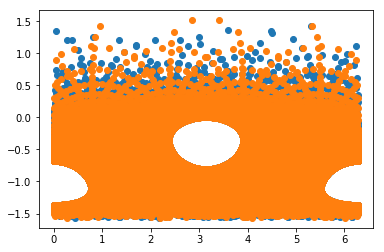

In [25]:
plt.plot(az1, alt1, 'o')
plt.plot(az2, alt2, 'o')

In [26]:
sco = schema_converter()
# Can grab from https://lsst-web.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs/baselines/baseline_1exp_pairsmix_10yrs.db
observations = sco.opsim2obs('baseline_1exp_pairsmix_10yrs.db')

# Crop down to year 1 to speed things up
observations = observations[np.where(observations['night'] < 367)]

In [27]:
n_collisions = np.zeros(observations.size)
n_sats_in_fov = np.zeros(observations.size)

In [28]:
mjd0 = observations[0]['mjd']
lmst = observations['lmst']/24.*2.*np.pi
radius_collide = np.radians(1.75)
exptime_offsets = [0, 0.5, 1.0]
# Let's just assume the lmst and alt,az don't change much over the exposure time.
i_max = np.size(observations)
for i,obs in enumerate(observations):
    sat_indx = []
    for offset in exptime_offsets:
        x,y,z = generate_sat_xyz(obs['mjd']-mjd0+obs['exptime']*offset)
        alt, az = sats2altaz(x,y,z, lmst[i])
        seperations = _angularSeparation(az, alt, obs['az'], obs['alt'])
        collided= np.where(seperations < radius_collide)[0]
        n_collisions[i] += collided.size
        sat_indx.extend(collided.tolist())
    n_sats_in_fov[i] = np.size(np.unique(sat_indx))
    progress = i/i_max*100
    text = "\rprogress= %.1f%%" % progress 
    sys.stdout.write(text)
    sys.stdout.flush()

progress= 100.0%

In [29]:
collided.tolist()

[]

In [30]:
n_collisions.max(), n_collisions.sum(), n_sats_in_fov.mean(), n_sats_in_fov.max()

(7.0, 68636.0, 0.30023577580738997, 7.0)

In [31]:
collide_indx = np.where(n_collisions > 0)[0]
np.size(collide_indx)

35769

In [32]:
np.unique(observations['note'][collide_indx])

array(['', 'DD:290', 'DD:COSMOS', 'DD:ECDFS', 'DD:ELAISS1', 'DD:XMM-LSS',
       'DD:u,290', 'DD:u,COSMOS', 'DD:u,ECDFS', 'DD:u,ELAISS1',
       'DD:u,XMM-LSS', 'blob, gr, a', 'blob, gr, b', 'blob, iz, a',
       'blob, iz, b', 'blob, ri, a', 'blob, ri, b', 'blob, u', 'blob, y',
       'blob, z'],
      dtype='<U40')

In [33]:
print('fraction of observations hit=', np.size(collide_indx)/np.size(observations))

fraction of observations hit= 0.15646502513046406


In [34]:
print('survey name   N_obs   N_with_sat    frac_with_sat')
for note in np.unique(observations['note'][collide_indx]):
    col_indx = np.where((observations['note'] == note) & (n_collisions > 0))[0]
    full_indx = np.where((observations['note'] == note))[0]
    print(note, full_indx.size, col_indx.size, col_indx.size/full_indx.size)

survey name   N_obs   N_with_sat    frac_with_sat
 27767 4443 0.16001008391255808
DD:290 960 167 0.17395833333333333
DD:COSMOS 2976 518 0.17405913978494625
DD:ECDFS 2326 374 0.16079105760963028
DD:ELAISS1 1848 219 0.1185064935064935
DD:XMM-LSS 1728 256 0.14814814814814814
DD:u,290 140 25 0.17857142857142858
DD:u,COSMOS 259 56 0.21621621621621623
DD:u,ECDFS 238 39 0.1638655462184874
DD:u,ELAISS1 189 17 0.08994708994708994
DD:u,XMM-LSS 175 30 0.17142857142857143
blob, gr, a 13296 2020 0.1519253910950662
blob, gr, b 13132 1980 0.1507767286018885
blob, iz, a 2252 355 0.15763765541740674
blob, iz, b 2210 329 0.14886877828054298
blob, ri, a 27994 4209 0.15035364721011646
blob, ri, b 27683 4051 0.14633529603005455
blob, u 18666 2787 0.1493089038894246
blob, y 43862 6904 0.15740276321189184
blob, z 40906 6990 0.17087957756808292
